## BERT Twitter disinformation classifier
In this notebooks a disinformation classifier for tweets is trained using a pre-trained BERT natural language processing model. Overview: 
1. Loading data
2. Explanatory data analysis
3. Data preparations
4. Tokenization
5. Fine-tune pre-trained BERT model and model predictions
6. Model perfomance on test data set

To build this classifier online tutorials were consulted, among others https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894.

### Load libraries

In [35]:
import nltk
import torch
import gensim
import numpy as np
import pandas as pd

# BERT transformers
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# notebook/markdown
from IPython.display import display, clear_output

# sklearn
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tensorflow/Keras tokenizer
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

# torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# tqdm
from tqdm.notebook import tqdm

### 1. Loading data

In [2]:
path = '../../data/Twitter_dataset/twitter_full.csv'
df = pd.read_csv(path)
df.head()

,#followers,user_engagement,verified,depth,user_id1,tweet_id1,user_id2,length,#hashs,#mentions,#URLs,sentiment_score,text,label
0,15375121,72.567469,1,0.0,ROOT,489800427152879616,2467791,95,0,0,2,-0.3182,malaysia airlines says it lost contact with pl...,1
1,3673898,55.294333,1,0.0,ROOT,560474897013415936,59553554,118,0,1,1,0.8398,for just $1 you can get a free jr. frosty with...,1
2,1274260,32.033388,1,0.0,ROOT,524928119955013632,19038934,133,1,0,0,-0.7269,police say they have located car belonging to ...,0
3,13955752,64.548896,1,0.0,ROOT,518830518792892416,51241574,96,0,0,1,-0.3400,mexico security forces hunting 43 missing stud...,1
4,189683,24.726166,1,0.0,ROOT,551117430345711616,2280470022,96,0,0,2,0.0000,news saudi arabia's national airline planning ...,1


### 2. Explanatory data analysis 
#### Lengths of tweets

In [3]:
tweet_ls = [tweet for tweet in df.text]

max_len = 0
tweet_len = []
for tweet in tweet_ls:
    tweet_len.append(len(tweet))

print('Number of tweets:', len(tweet_ls))
print('Max length of tweet:', max(tweet_len))
print('Mean length of tweets:', np.mean(tweet_len))

Number of tweets: 741
Max length of tweet: 140
Mean length of tweets: 91.59784075573549


### 3. Data preperations
#### Selection and randomization

In [4]:
# select source tweets and prediction labels
df = df[['text','label']]

# randomize data frame
df = shuffle(df).reset_index(drop=True)
df.head()

,text,label
0,a pregnant woman has lost her eye after being ...,0
1,hp confirmed that it's splitting into two comp...,0
2,"#walmart donates $10,000 to #darrenwilson fund...",1
3,that powerful letter from lego to parents from...,0
4,currently boycotting walmart & sam's on w. flo...,1


#### Split data intro train, validation and test set

In [5]:
# test set
train_val_df = df.sample(frac = 0.8)
test_df = df.drop(train_val_df.index)

# train and validation set
train_df = train_val_df.sample(frac = 0.8)
val_df = train_val_df.drop(train_df.index)

# reset index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('shape trainset:', train_df.shape)
print('shape valset:', val_df.shape)
print('shape testset:', test_df.shape)

shape trainset: (474, 2)
shape valset: (119, 2)
shape testset: (148, 2)


#### Export train, validation and test set to .tsv format

In [6]:
# train_df.to_csv('./train.tsv', sep='\t', index=False)
# val_df.to_csv('./val.tsv', sep='\t', index=False)
# test_df.to_csv('./test.tsv', sep='\t', index=False)

#### Concatenate data again

In [7]:
df = pd.concat([train_df, val_df, test_df])

#### Data Cleaning: Removing stopwords from all source tweets (train, validation and test set)

In [10]:
# dowload stopwords from nltk library
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jurriaanparie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# remove stopwords and words with ≤2 characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [12]:
# load stopwords from nltk
stop_words = stopwords.words('english')

# cleaning source tweets
df['cleaned'] = df['text'].apply(preprocess)

### Words in dataset after cleaning

In [13]:
words_ls = []
for i in df.cleaned:
    for j in i:
        words_ls.append(j)

words = len(list(set(words_ls)))
words

2046

### 4. Tokenization
#### Tokenize source tweets using Tensorflow's one-hot tokenization function

In [14]:
# tokenize source tweets 
tokenizer = Tokenizer(num_words = words)
tokenizer.fit_on_texts(train_df['text'])

In [15]:
# Create sequence of tokenized words for train, validation and test set 
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
val_sequences = tokenizer.texts_to_sequences(val_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

### 5. Fine-tune pre-trained BERT model
#### Load pre-trained BERT model

In [16]:
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

#### Create class for datasets

In [17]:
class TwitterDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv('./' + mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer
    
    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
            
        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)
        
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len

#### Initialize train, validation and test data set for transformation

In [23]:
# Initialize Datasets for Transformation
train_set = TwitterDataset('train', tokenizer=tokenizer)
val_set = TwitterDataset('val', tokenizer=tokenizer)
test_set = TwitterDataset('test', tokenizer=tokenizer)

print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 474
valset size: 119
testset size:  148


#### Initialize sampling and observing tensors

In [24]:
sample_idx = 0

statement, label = trainset.df.iloc[sample_idx].values

tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

print(f"""
original_statement: 
{statement}

tokens: 
{tokens}

label: {label}

--------------------

tokens_tensor: 
{tokens_tensor}

segments_tensor: 
{segments_tensor}

label_tensor: 
{label_tensor}

""")


original_statement: 
remembering paul walker: fast and furious star was "so happy" hours before his tragic death URL

tokens: 
['[CLS]', 'remembering', 'paul', 'walker', ':', 'fast', 'and', 'furious', 'star', 'was', '"', 'so', 'happy', '"', 'hours', 'before', 'his', 'tragic', 'death', 'ur', '##l', '[SEP]']

label: 0

--------------------

tokens_tensor: 
tensor([  101, 10397,  2703,  5232,  1024,  3435,  1998,  9943,  2732,  2001,
         1000,  2061,  3407,  1000,  2847,  2077,  2010, 13800,  2331, 24471,
         2140,   102])

segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

label_tensor: 
0




#### Transforming dataset

In [25]:
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    # labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # zero padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids

BATCH_SIZE = 16
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(val_set, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [28]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([16, 30]) 
tensor([[  101, 10397,  2703,  5232,  1024,  3435,  1998,  9943,  2732,  2001,
          1000,  2061,  3407,  1000,  2847,  2077,  2010, 13800,  2331, 24471,
          2140,   102,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101, 10651,  1024,  8443,  3003,  1999,  2680,  2655,  1024,  2057,
          2074,  2915,  2091,  1037,  4946,  1006,  2394,  4942, 27430,  1007,
         24471,  2140,  1001,  1049,  2232, 16576, 24471,  2140,   102,     0],
        [  101,  3516,  2450, 12778,  1002,  2322,  1010,  2199,  2005,  2353,
          7388,  1064, 24471,  2140, 24471,  2140,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1001,  1049,  2232, 16576,  2003,  3373,  2915,  2091,  2007,
          2214,  3354,  1011,  2328, 20934,  2243,  3302,  1011,  2000,  1011,
          2250,  7421,  2291,  1012, 24471,  2140, 24471,  2140,   102,     0],


#### Model Construction

In [29]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

print("""
name             module
-----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:16} {}".format(name, module))


name             module
-----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout          Dropout(p=0.1, inplace=False)
classifier       Linear(in_features=768, out_features=2, bias=True)


In [30]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### Fine-tuning BERT and make predictions 

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
NUM_EPOCHS = 3

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        loss.backward()
        optimizer.step()

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

device: cpu


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [43]:
# torch.save(model, './best_model.pth')
# print('Model saved!')

### 6. Model performance on test data set

Acc:  0.8648648648648649


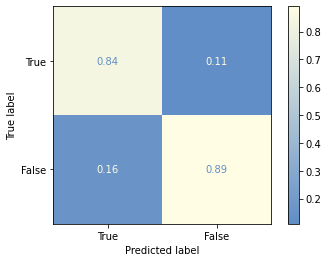

In [41]:
true=[]
predictions=[]
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
            
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())


cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')

cmap0 = mpl.colors.LinearSegmentedColormap.from_list(
        'unevently divided', ['#618EC7','#fffde4'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['True', 'False'])
disp.plot(cmap=cmap0)

print('Acc: ', accuracy_score(predictions,true))

#### Dataframe with ground truth and predicted labels

In [42]:
df = pd.DataFrame({"pred_label": predictions})
df_true = pd.DataFrame({"label": true})

df_pred = pd.concat([test_df.loc[:, ['text']], 
                     df_true.loc[:, ['label']], 
                     df.loc[:, 'pred_label']], axis=1)
df_pred.head()

,text,label,pred_label
0,marlboro man dies of smoking-related disease U...,0,1
1,#oklahoma prosecutor files formal notification...,0,0
2,#mexico: doubts grow over the fate of 43 missi...,0,0
3,who killed deandre joshua - and why? still mor...,1,0
4,i feel some type of way. URL,1,1


#### Export model predictions to `.csv` file

In [44]:
df_pred.to_csv('./pred_BERT.csv', index=False)